### Example: Testing multi-sequences Pattern Recognition

This example demonstrates how to use the Shape and finder_multi classes to detect a known multi 2D pattern within a larger set of dataset (target). The aim is to test the ability of the model to:

- Recognize identical multi-patterns within several dataset

- Match modified versions of the pattern based on weighted input

- Predict the future values

We generate synthetic data to create three variables (the one to predict + two covariates) to validate the performance.

In [1]:
from shapefinder import Shape,finder_multi
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

We create simulated historical data using random walk time series. Three datasets (df1, df2, df3) are generated to represent the historical data of three variables: the target variable to forecast and two covariates. Then, we create three input shapes, each simulating the input pattern for one of the variables.

In [2]:
### Define the three variables and the three input shapes 

# Set a seed for reproducibility
np.random.seed(5) 

# Daily dates over 100 days
date_range = pd.date_range(start='2025-01-01', periods=100, freq='D')

# Function to Generate Random Walk Time Series. 
# Create a DataFrame with `s` random walk time series, each of length `c`.
def create_time_series_df(s=60,c=100):
    data = {f"series_{i+1}": np.cumsum(np.random.randn(c)) for i in range(s)}
    df = pd.DataFrame(data, index=date_range[:c])
    return df

# Generate Main and Covariate Datasets
df1 = create_time_series_df()
df2 = create_time_series_df()
df3 = create_time_series_df()

# Input Shape Time Series (Target Patterns)
inp_1= create_time_series_df(s=1,c=6).iloc[:,0]
inp_2= create_time_series_df(s=1,c=6).iloc[:,0]
inp_3= create_time_series_df(s=1,c=6).iloc[:,0]

# Assign Datasets and Shapes
data = df1             # Main time series data
cov = [df2, df3]       # List of covariate datasets


In [3]:
# Instantiate the shape objects and load the patterns
shape = Shape()
shape.set_shape(inp_1)  # Main variable input
shape_cov1 = Shape()
shape_cov1.set_shape(inp_2) # Covariate 1 input
shape_cov2 = Shape()
shape_cov2.set_shape(inp_3) # Covariate 2 input
shape_cov = [shape_cov1,shape_cov2]

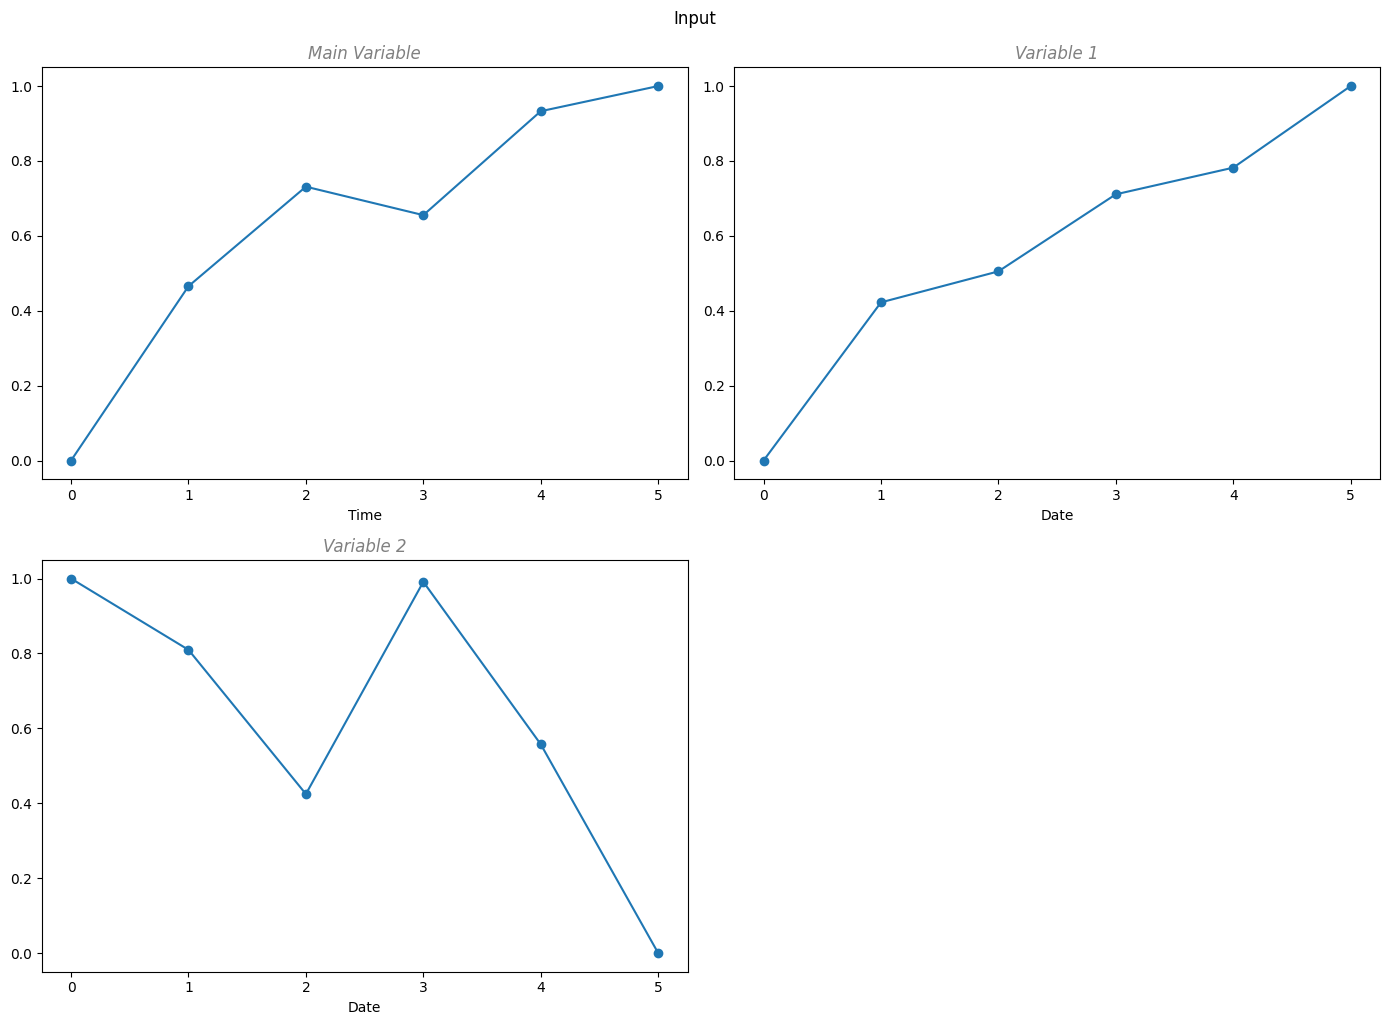

In [4]:
# Initialize finder with data and shape targets
find = finder_multi(data,cov,shape,shape_cov)

# Visualize the Input Patterns
find.plot_inputs()

The target variable and the first covariate have similar shapes, both showing a nearly constant upward trend over time. The input shape of the second covariate has a "thunderbolt" pattern, with a slight decline, followed by an increase, and then a sharper drop. 

In [5]:
# First Pattern Matching (Unweighted)
find.find_patterns(
    min_d=0.9,         # Minimum DTW similarity
    select=True,       # No overlapping window allowed
    metric='dtw',      # Distance metric: Dynamic Time Warping
    min_mat=5          # Minimum number of matched patterns
)

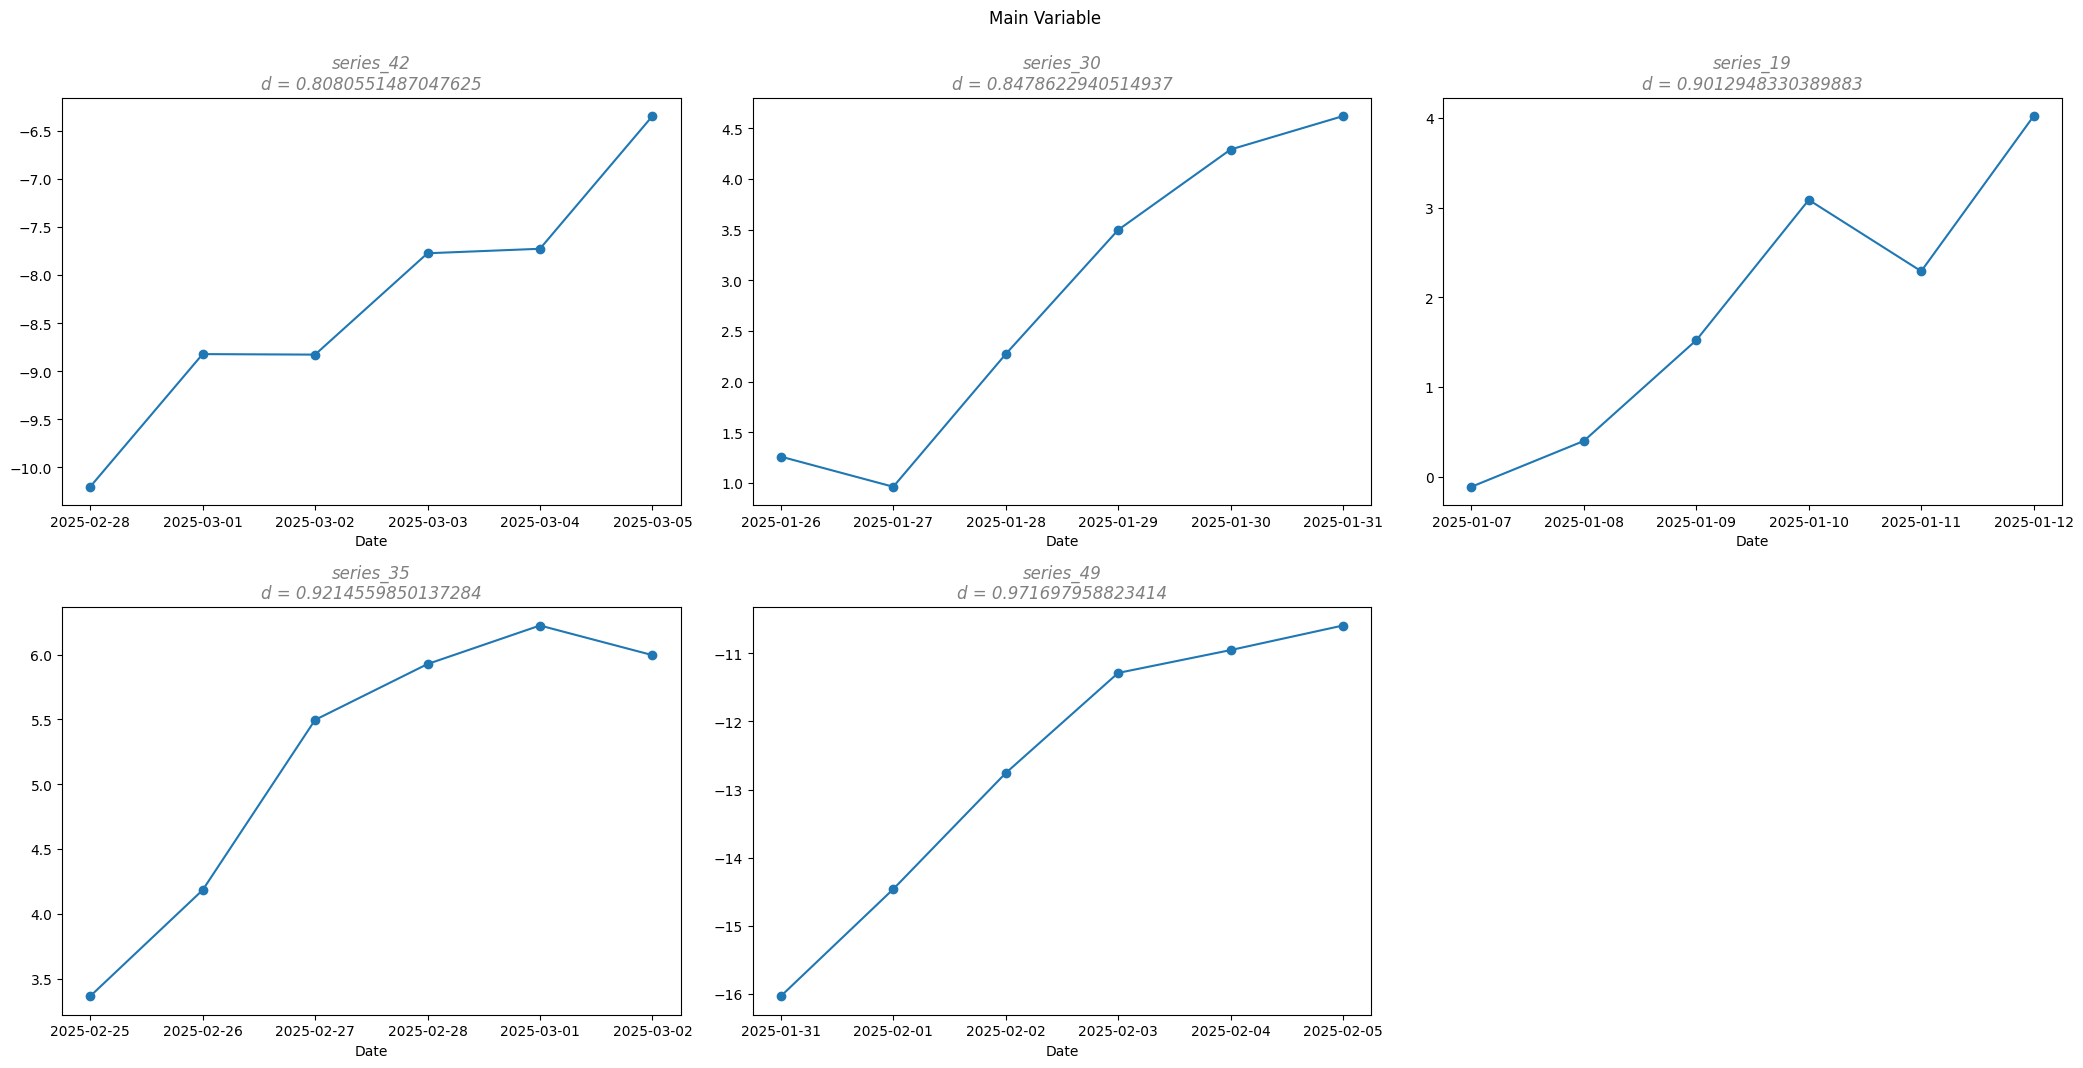

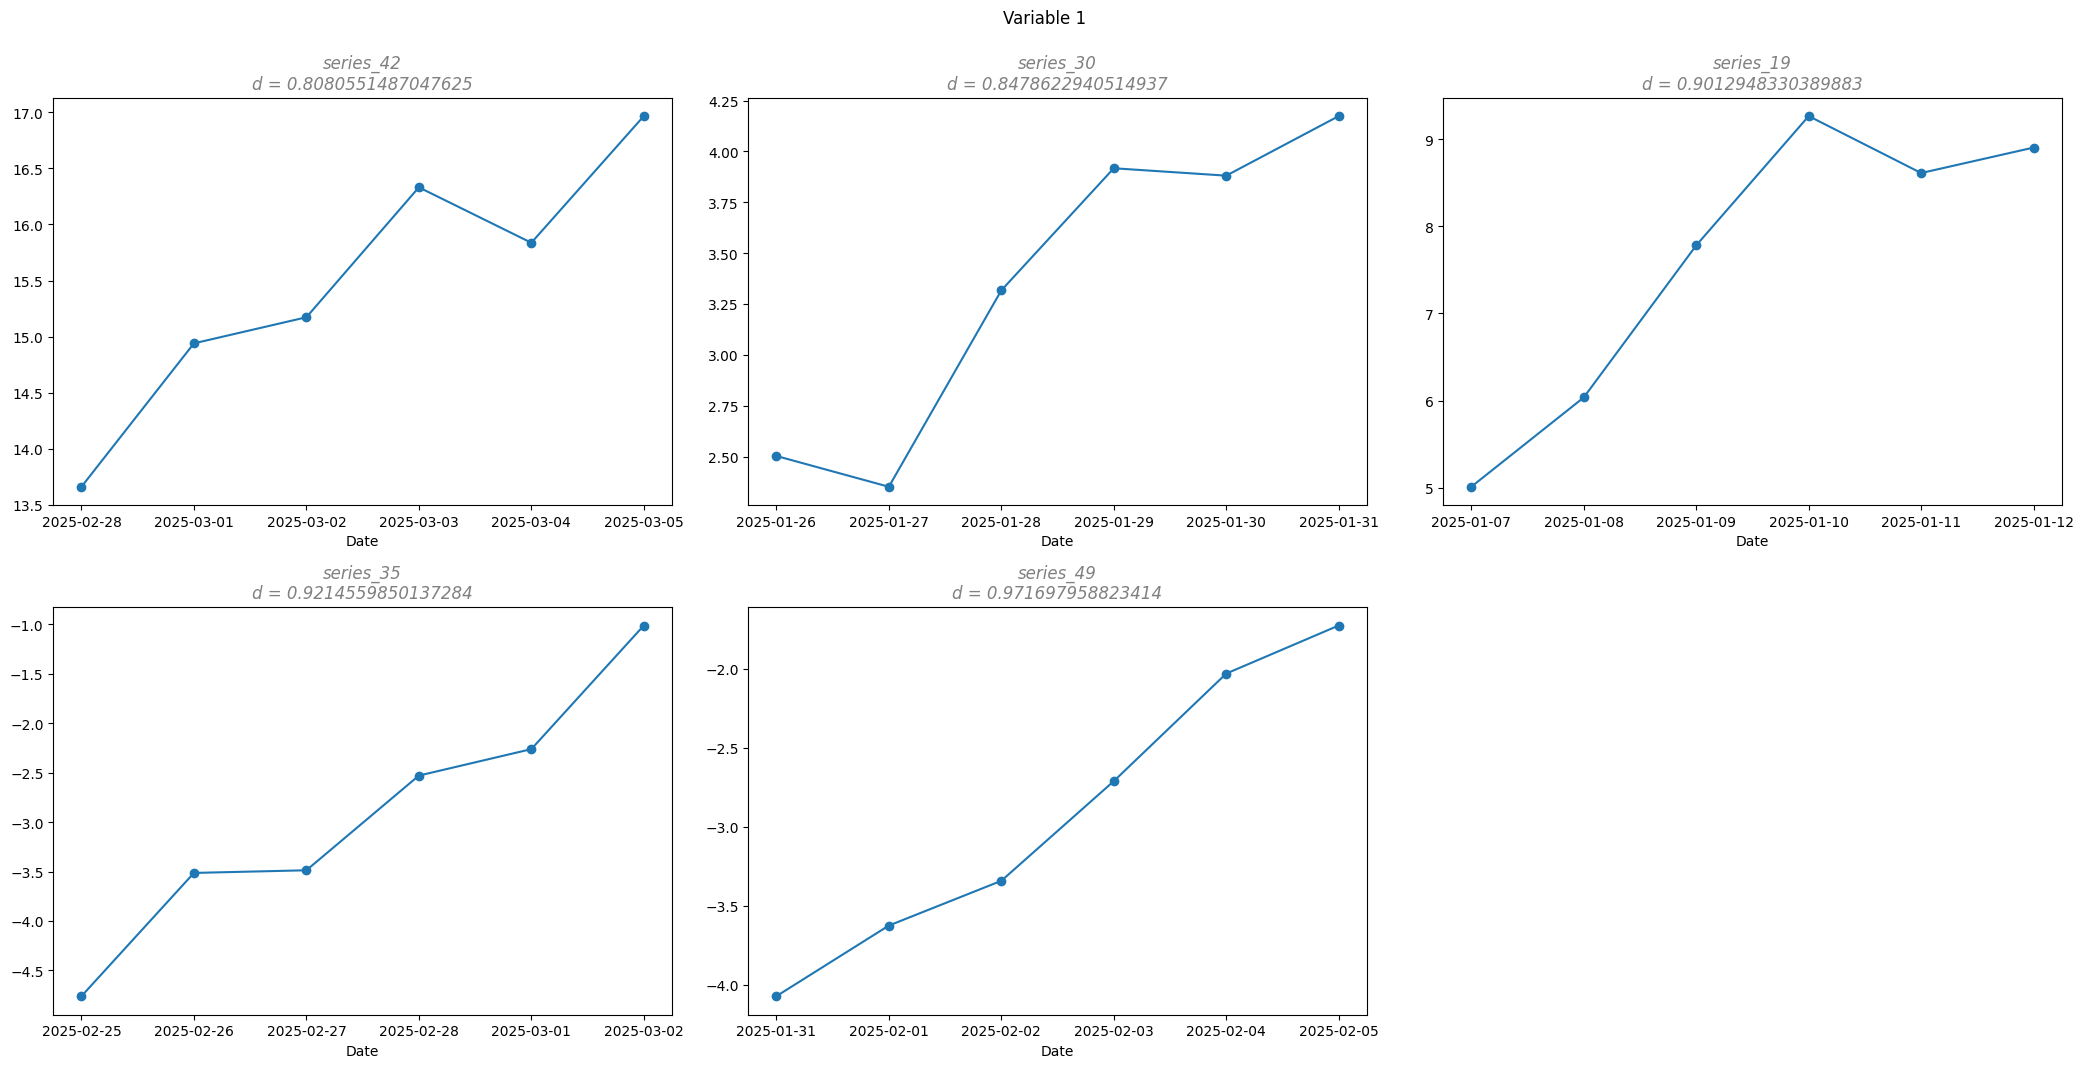

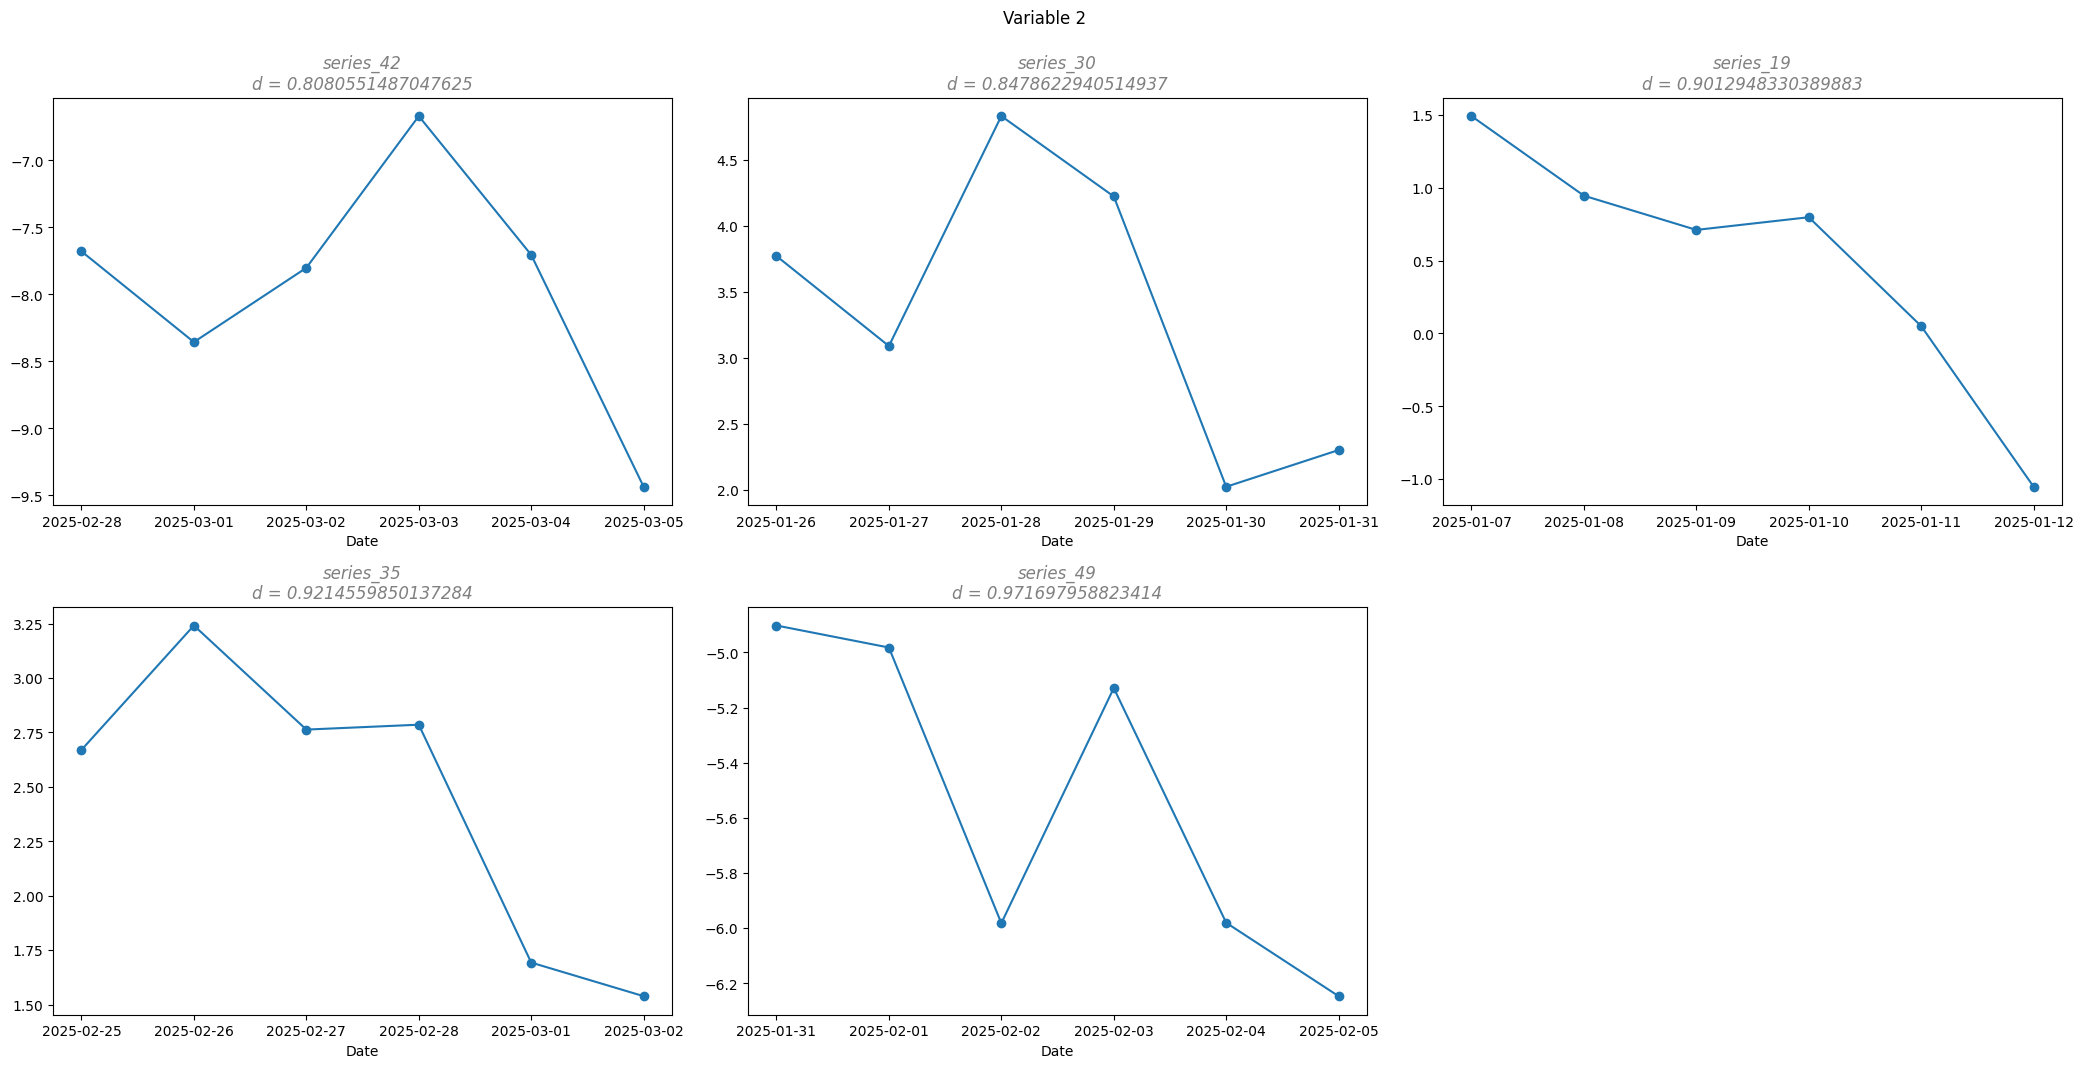

In [6]:
# Plot all matched sequences in data + covariates
find.plot_sequences(how='total', cov=True)  

The model found similar patterns in the historical data:

- For the first two variables, the matched sequences are very close to the input shapes.
- For the third variable, only the first two matches are good. The other three matches are less accurate.

This is also seen in the distance values — the last three matches for the third variable all have a distance above 0.9.

In [7]:
 # Make prediction for next 3 steps (no covariate weighting)
pred_ori_no_weight = find.predict(horizon=3) 

We change the weights to see if the model lead to different outcomes. We look now only for similar patterns of the main variable and the secodn covariate. 

In [8]:
# Second Pattern Matching (Weighted Covariates)
find.find_patterns(
    min_d=0.9,
    select=True,
    metric='dtw',
    min_mat=5,
    weight=[1.5, 0, 1.5]  # Assign weights to covariates (emphasizing main and cov2 variable equally, ignoring cov1)
)

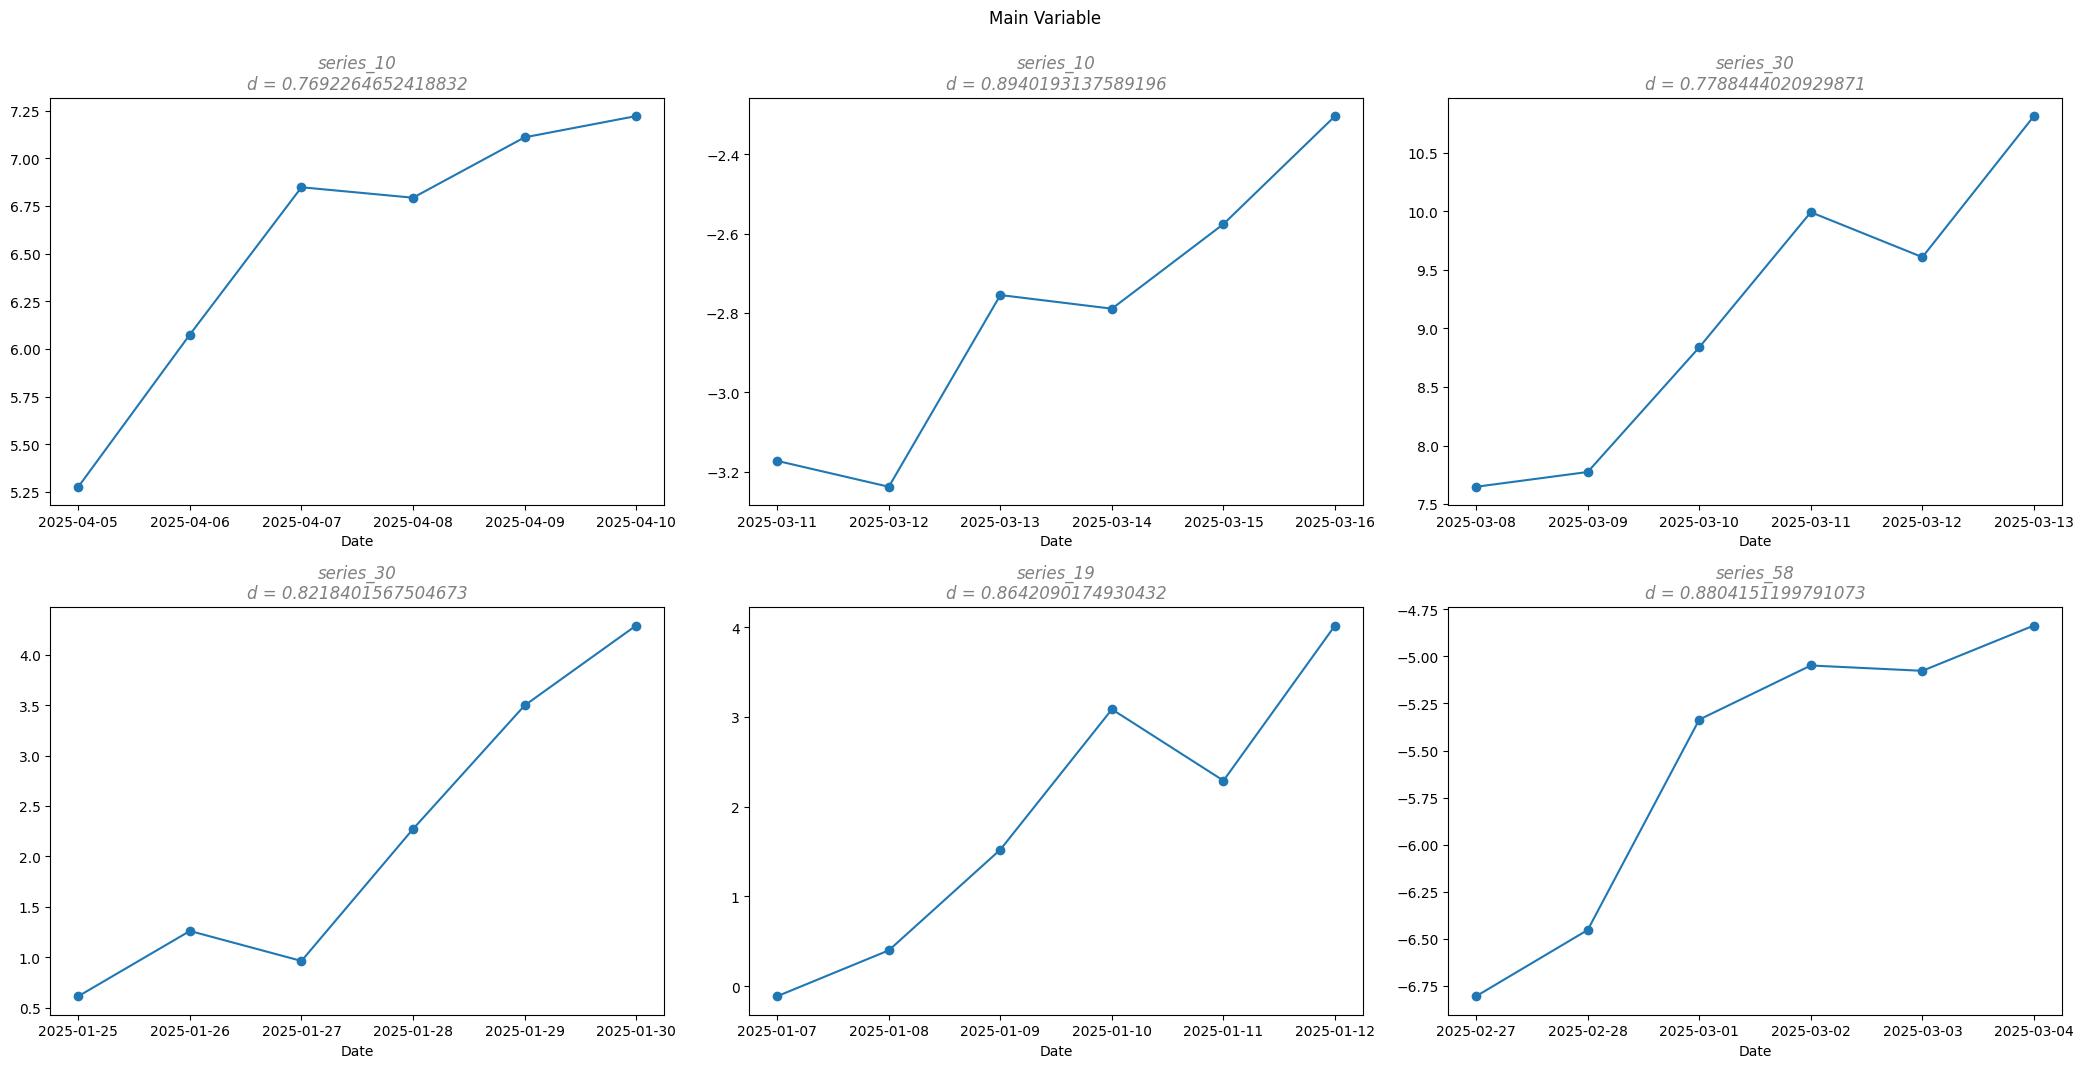

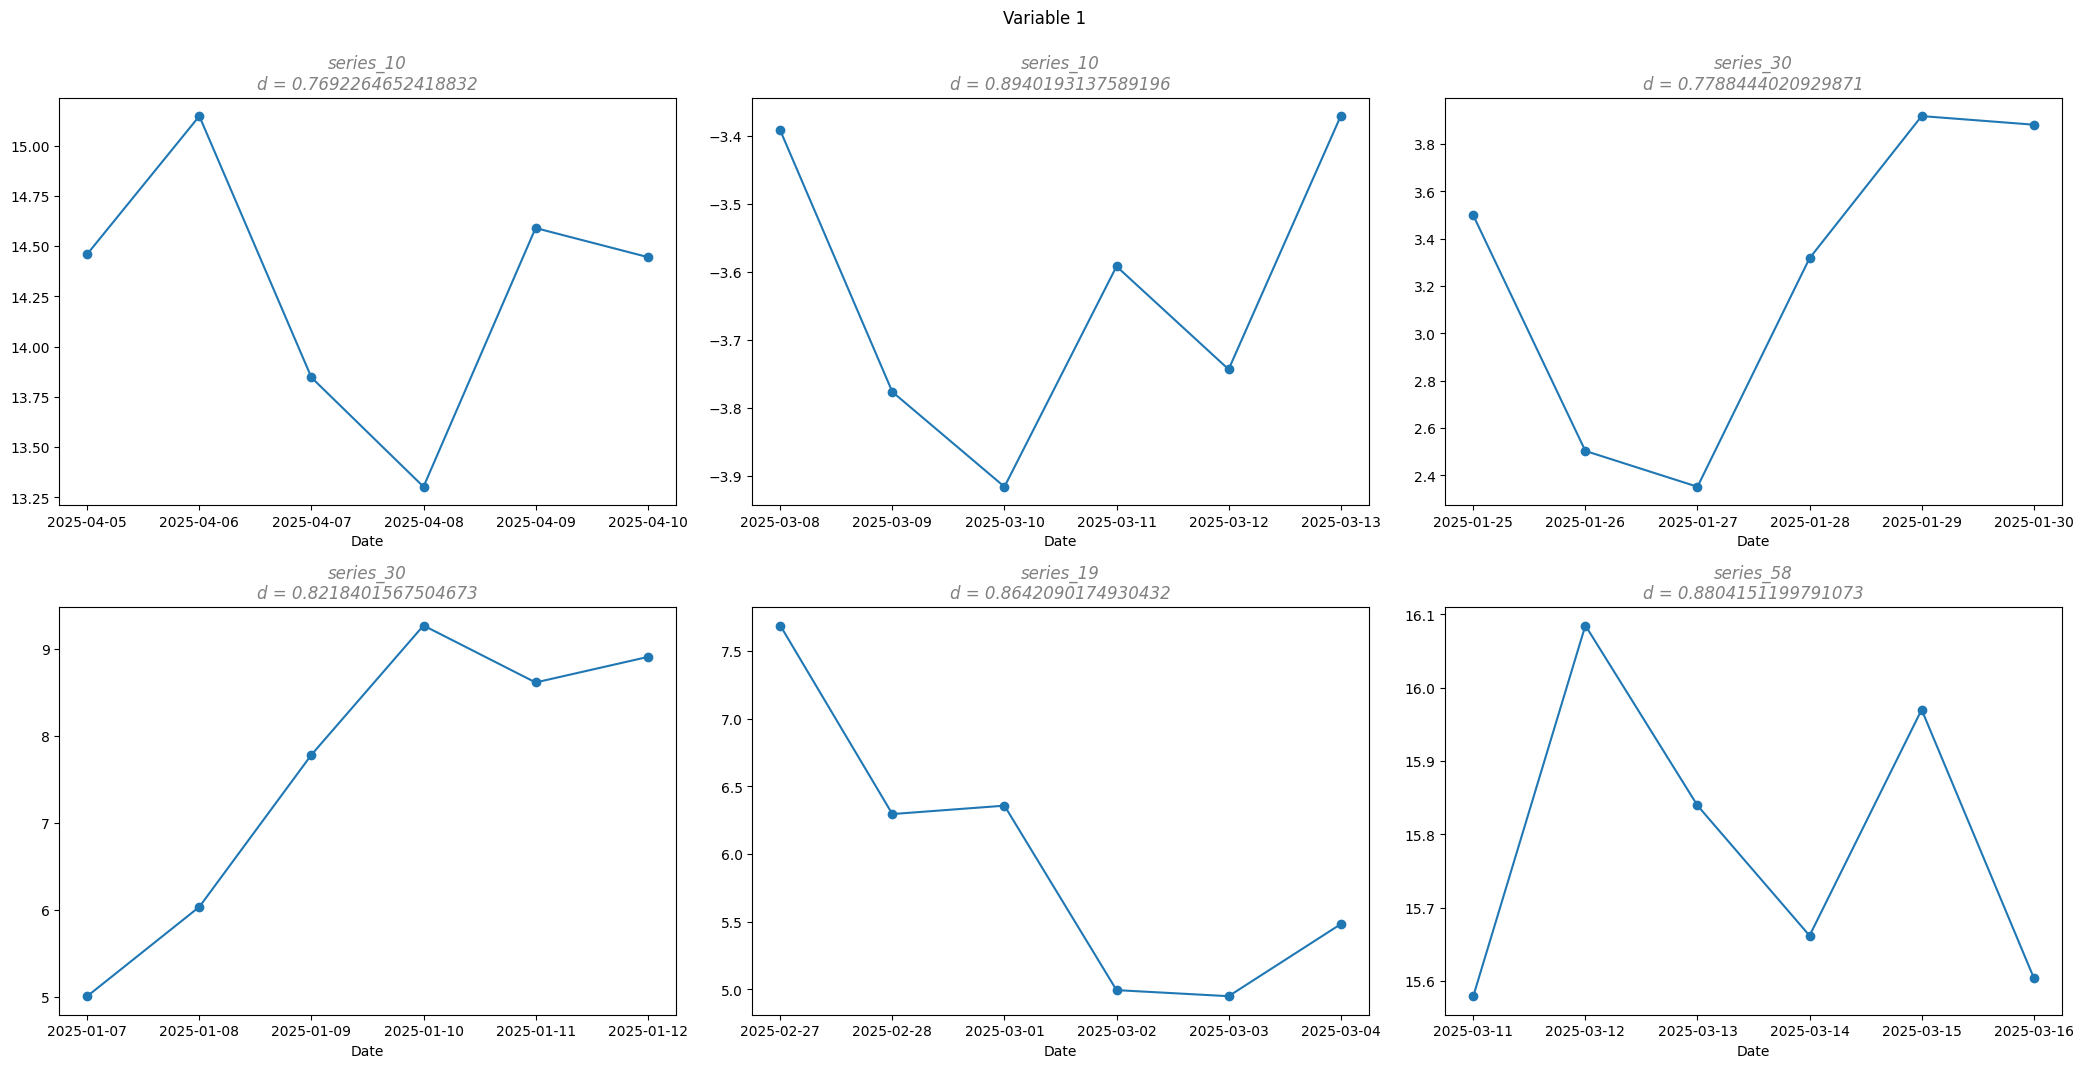

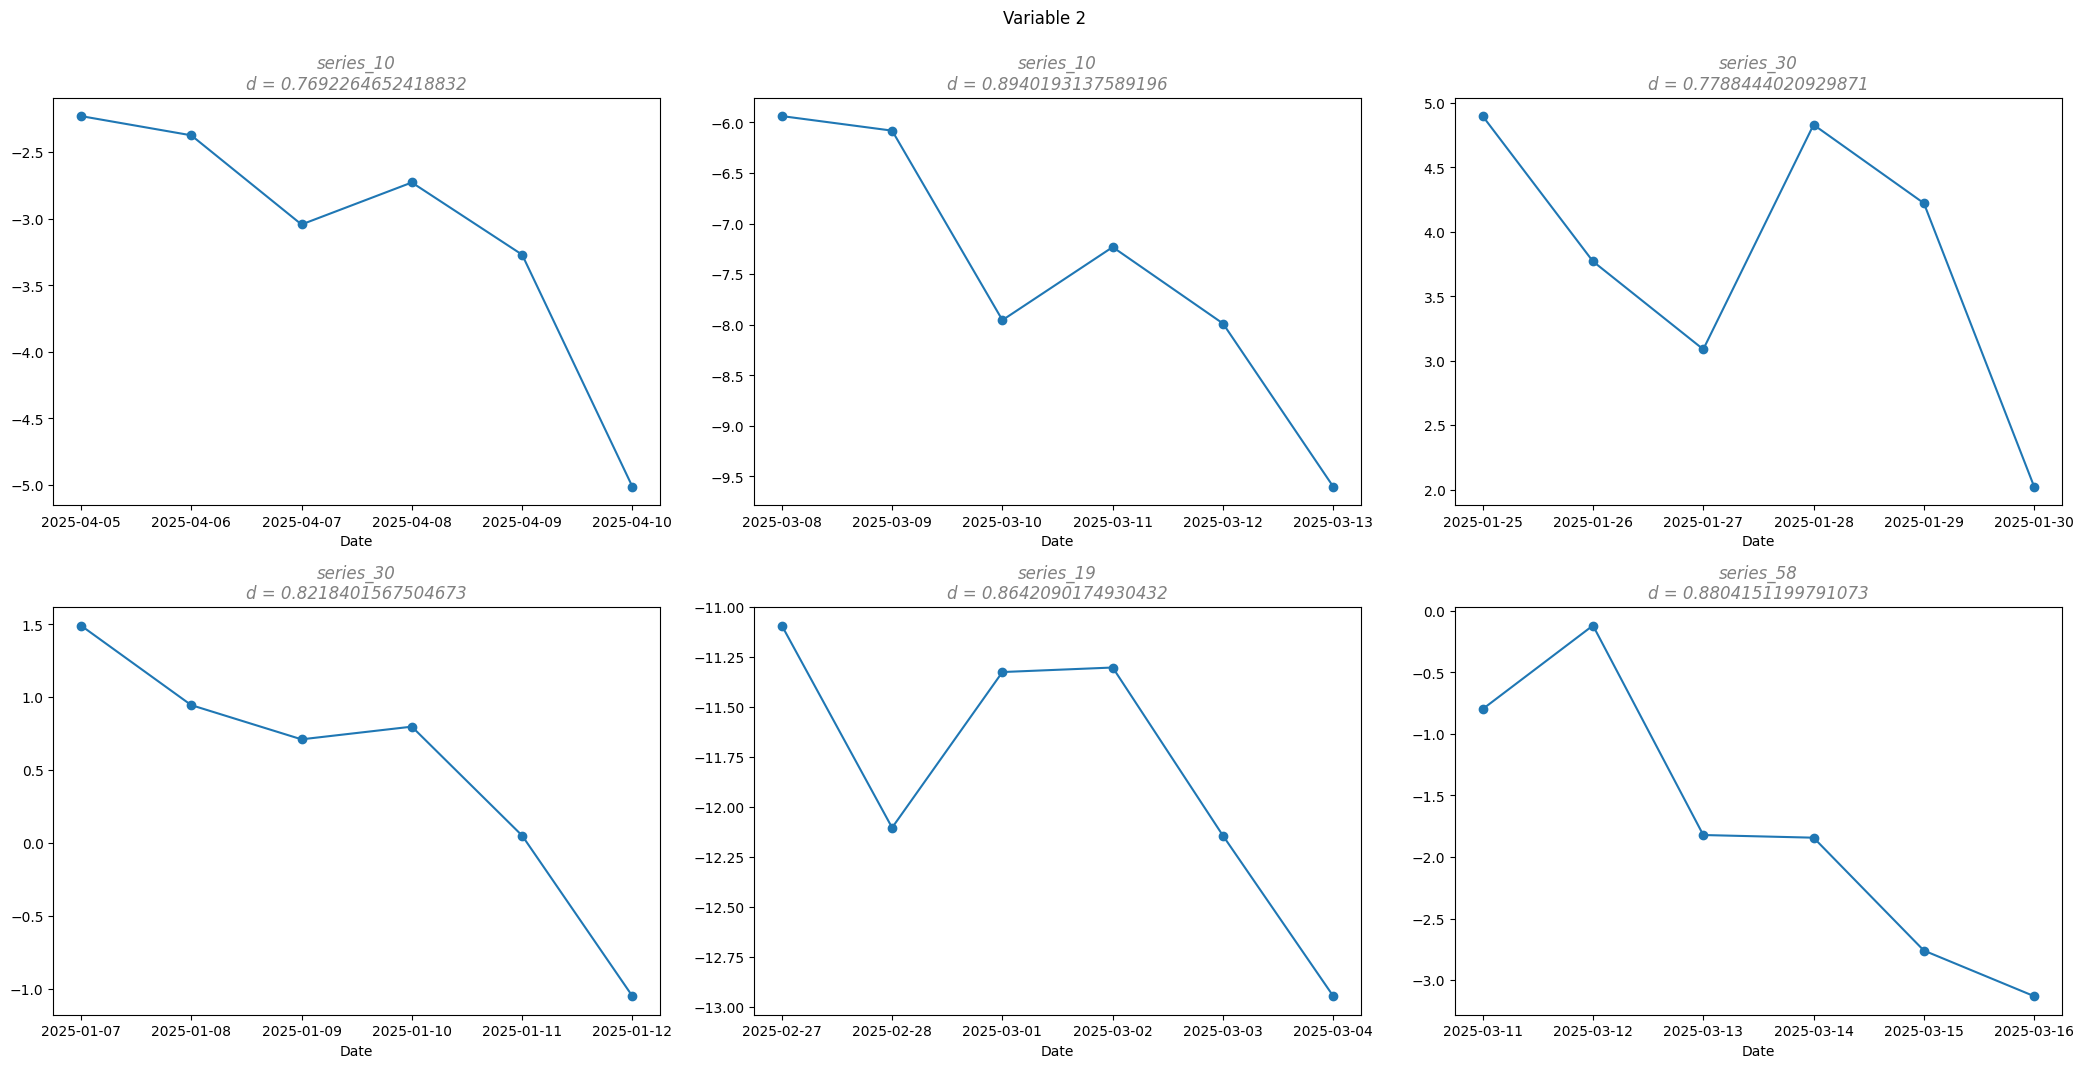

In [9]:
# Visualize sequences with weights applied
find.plot_sequences(how='total', cov=True)  

We see similar results for the main variable, but the two covariates show different outcomes:

- The first covariate matches appear random — which makes sense since it's not considered in the model (weight = 0).
- For the second covariate, the matched shapes are more similar than in the previous run, as the model gives it more focus.

This is also reflected in the distance values — all are below 0.9, indicating better matches.

In [10]:
# Make new prediction with weighted covariates
pred_ori = find.predict(horizon=3)  

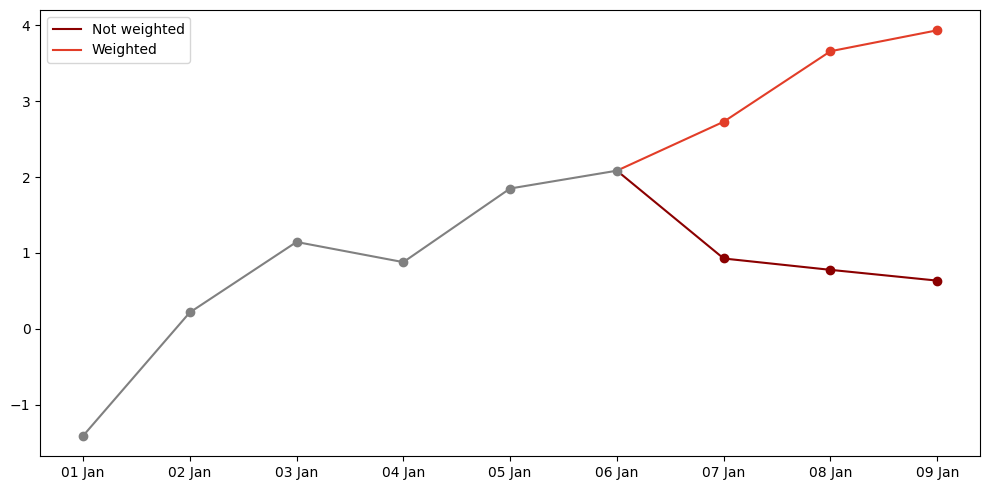

In [11]:
# Plot the two predictions (unweighted + weighted)

# Rescale Predictions to Original Scale
# The predictions (between 0 and 1) are rescaled using the input shape's min and max
pred_ori = pred_ori * (inp_1.max() - inp_1.min()) + inp_1.min()
pred_ori_no_weight = pred_ori_no_weight * (inp_1.max() - inp_1.min()) + inp_1.min()

# Convert Predictions to Series and Set Date Index 
# The forecast horizon is 3 days, starting right after the input ends (input ends on Jan 6)
pred_ori = pd.Series(pred_ori)
pred_ori.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

pred_ori_no_weight = pd.Series(pred_ori_no_weight)
pred_ori_no_weight.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

# Add Last Input Point to Each Prediction Series for Plotting Continuity
pred_ori_l = pd.concat([inp_1.iloc[-1:], pred_ori])
pred_ori_no_weight_l = pd.concat([inp_1.iloc[-1:], pred_ori_no_weight])

# Plot Input and Forecasts (Weighted vs Not Weighted)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pred_ori_no_weight, marker='o', color='#8B0000',linewidth=0)
ax.plot(pred_ori_no_weight_l, color='#8B0000', label='Not weighted')
ax.plot(pred_ori, marker='o', color='#E23D28',linewidth=0)
ax.plot(pred_ori_l, color='#E23D28', label='Weighted')
ax.plot(inp_1, marker='o', color='grey')
ax.xaxis.set_major_formatter(DateFormatter('%d %b'))
plt.legend()
plt.tight_layout()
plt.show()
